# Определение возраста покупателей по фотографии (Computer Vision)


### Для компаний в сферах деятельности:
- Научные отделы / R&D центры / Институты / Резиденты наукоградов
- Информационная безопасность
- Ритейл / E-commerce
- Стартапы
- IT-компания
- Услуги для бизнеса [b2b] (аутсорс консалтинг аудит)

### Задачи проекта:
Построить модель, которая по фотографии определит приблизительный возраст человека. Есть набор фотографий людей с указанием возраста.

### Ключевые слова:
Computer Vision,  Video Analysis, Image, video enhancement (HDR, trailing smear, Image distortion and so on). Stereo Vision and Binocular Calibration. Face/body/vehicle attribute and feature recognition (structured and semi-structured), object detection, Re-ID, Face verification and identification, landmarks, identification tracking algorithm, 3D reconstruction, Structure-from-motion, Image filtration. Augmented reality, Virtual reality, Image retrieval, data science, machine learning, ML, Python, SQL, Git, Pandas, Numpy, Matplotlib, seaborn, Sklearn, Keras, Tableau, Spark, Hadoop, R, sci-py, Research, Kaggle, Algorithms, PyTorch, TensorFlow, CatBoost, RNN, SVN, NLP, DNN, Deep Learning, xgboost, Support vector machines, reccurent neural networks, нейронные сети, градиентный бустинг, нелинейная оптимизация, кластеризация, random forest, descision trees,  regression,  Reinforcement Learning, neural networks, artificial intelligence, OpenCV, PIL

### Навыки и инструменты
Pandas
keras
Matplotlib
Seaborn
компьютерное зрение
машинное обучение

### Описание проекта
Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Построена модель, которая по фотографии определит приблизительный возраст человека. 
Проанализирован набор фотографий людей с указанием возраста при помощи компьютерного зрения с привлечением готовых нейронных сетей и библиотеки Keras.

### План по выполнению проекта
- Проведём исследовательский анализ набора фотографий.
- Подготовим данные к обучению.
- Обучим нейронную сеть и рассчитаем её качество.

### Импортируем необходимые библиотеки для работы

In [1]:
import pandas as pd
import numpy as np
np.random.seed(12345)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt

## 1. Исследовательский анализ данных

Загрузим датасет, в котором каждой фотографии присвлен возврат человека. Выведем датасет на экран.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from io import BytesIO
import requests
spreadsheet_id = 'ID'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
labels = pd.read_csv(BytesIO(r.content), sep=';')
labels

,file_name,real_age
0,000000.jpg_face.jpg,4
1,000001.jpg_face.jpg,18
2,000002.jpg_face.jpg,80
3,000003.jpg_face.jpg,50
4,000004.jpg_face.jpg,17
...,...,...
7586,007608.jpg_face.jpg,14
7587,007609.jpg_face.jpg,37
7588,007610.jpg_face.jpg,28
7589,007611.jpg_face.jpg,20


Загрузим фотографии из директории

In [4]:
%%time
directory = '/final_files'
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        validate_filenames=True,
        dataframe=labels,
        directory=directory,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.
CPU times: user 290 ms, sys: 446 ms, total: 736 ms
Wall time: 2min


### 2. Исследовательский анализ набора фотографий

Выведем информацию о таблице

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Иммеем датасет из двух признаков: имя файла фото и возраст. Без пропусков. Папка фото содержит 7591 файлов.

Построим гистограмму и боксплот распределения возраста в датасете

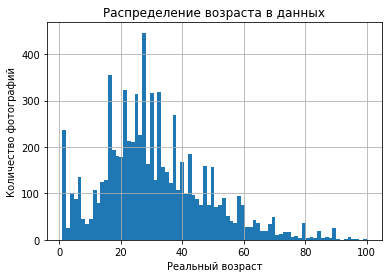

In [6]:
labels.hist(bins=80)
plt.title('Распределение возраста в данных')
plt.xlabel('Реальный возраст')
plt.ylabel('Количество фотографий')
plt.show()

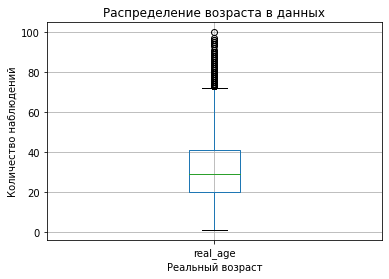

In [7]:
labels.boxplot('real_age')
plt.title('Распределение возраста в данных')
plt.xlabel('Реальный возраст')
plt.ylabel('Количество наблюдений')
plt.show()

In [8]:
print('Минимальный возраст:', labels['real_age'].min())
print('Максимальный возраст:', labels['real_age'].max())
print('Средний возраст:', labels['real_age'].mean())
print('Медиана возраста:', labels['real_age'].median())

Минимальный возраст: 1
Максимальный возраст: 100
Средний возраст: 31.20115926755368
Медиана возраста: 29.0


- Возвраст распределен неравномерно. Большинство фото с маркером возраста от 10 до 45 лет. 
- Встерчаются фото с признаком 1 и 100 лет.
- Средний возраст 31 год, медианная величина 
- Наблюдается небольшая бимодальность. Предположительно в данные подмешана дополнительная выборка, которая делает график двугорбым. Например, фото школьников. Это позволит определить несовершеннолетних.
- Фотографии пожилых людей мало, возможно повлияет на качество обученияв сторону понижения.
- Имеются фотографии младенцев и очень старых людей 90-100 лет.

Выведем на экран 30 фотографий

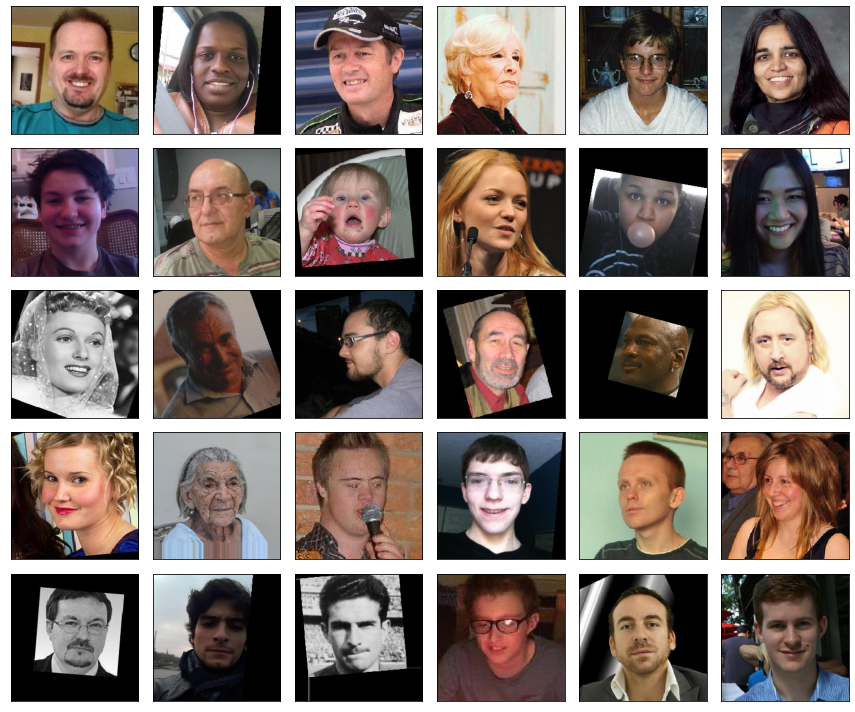

In [9]:
features, target = next(train_datagen_flow)
# выводим 25 изображений
fig = plt.figure(figsize=(12,10))
for i in range(30):
    fig.add_subplot(5, 6, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- В датасете есть старые и черно-белые фотографии. Имеет смысл делать аугментацию с тем, чтобы делать фотографию чёрно-белой в некотором проценте случаев (нету в стандартном наборе). Возможно, стоит подкрутить цветовые каналы или яркость

- В данные есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +/- 15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона

- В датасете имеются фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев

- В данные присутсвуют фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев

- В датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек полностью). Имеет смысл делать аугментацию с обрезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба

# 2. Обучение модели

In [10]:
%%time
def load_train(path):
    labels = pd.read_csv(BytesIO(r.content), sep=';')
    train_datagen = ImageDataGenerator(
                                       validation_split=0.25, 
                                       rescale=1./255,
                                       )
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_data
 
 
def load_test(path):
    labels = pd.read_csv(BytesIO(r.content), sep=';')
    test_datagen = ImageDataGenerator(
                                       validation_split=0.25, 
                                       rescale=1./255,
                                       )
    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_data
 
 
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=128, epochs=18, 
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data, validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model


path = '/faces/'
train_data = load_train(path)
test_data = load_test(path)
input_shape = (224,224,3)
model = create_model(input_shape)
train_model(model, train_data, test_data)    

Found 5694 validated image filenames.
Found 1897 validated image filenames.
94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/18
178/178 - 1867s - loss: 262.4336 - mae: 11.6454 - val_loss: 1022.8360 - val_mae: 27.3131
Epoch 2/18
178/178 - 69s - loss: 72.3407 - mae: 6.4466 - val_loss: 989.5369 - val_mae: 26.7570
Epoch 3/18
178/178 - 70s - loss: 36.2099 - mae: 4.6616 - val_loss: 677.8618 - val_mae: 21.2343
Epoch 4/18
178/178 - 72s - loss: 23.4322 - mae: 3.7224 - val_loss: 163.3963 - val_mae: 10.1861
Epoch 5/18
178/178 - 72s - loss: 19.7131 - mae: 3.4148 - val_loss: 81.2523 - val_mae: 6.8716
Epoch 6/18
178/178 - 73s - loss: 17.2768 - mae: 3.1978 - val_loss: 111.8967 - val_mae: 8.0195
Epoch 7/18
178/178 - 73s - loss: 16.3939 - mae: 3.1033 - val_loss: 66.1700 - val_mae: 6.2242
Epoch 8/18
178/178 - 73s - loss: 15.7557 - mae: 3.0530 - val_loss: 79.5143 - val_mae: 6.9687
Epoch 9/18
178/178 - 73s - loss: 14.5823 - mae: 2.9476 - val_loss: 89.6273 - val_mae: 7.1709
Epoch 10

Mae test: 6.07


### Результат обучения модели

В модели мы задали шаг обучения 0,0001, 18 эпох, функцию потерь среднюю квадратичную ошибку и метрику качества среднюю абсолютнаю ошибку. Аугументация ухудшала качество модели, поэтому мы не стали её применять при обучении модели.

# 3. Анализ обученной модели

- Мы обучили модель для определения возвраста покупателей по фотографии для сетевого супермаркета. 
- Модель имеет метрику качества Средняя абсолютная ошибка равная 6.07 - это лучше заданного предела (7). 
- Со временем супермаркет накопит базу данных фото своих покупателей и можно будет дообучить модель, что позволит улучшить качество модели и определение возраста станет более точное. 
- А это означает, что бизнес сможет более прицельно предлагать товары покупателям, что увеличит выручку компании.